In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/post-processing-done/processed.csv


In [2]:
df = pd.read_csv("/kaggle/input/post-processing-done/processed.csv")
df

,Unnamed: 0,ACCT_AGE,LIMIT,OUTS,ACCT_RESIDUAL_TENURE,LOAN_TENURE,INSTALAMT,SI_FLG,AGE,VINTAGE,...,INCOME_BAND1_G,INCOME_BAND1_H,AGREG_GROUP_#Housing Loan,AGREG_GROUP_#Total Auto Loan,AGREG_GROUP_#Total Xpress Credit,PRODUCT_TYPE_EDUCATION LOAN,PRODUCT_TYPE_HOME LOAN,PRODUCT_TYPE_PERSONAL LOAN,TIME_PERIOD_JAN25,TIME_PERIOD_NOV24
0,0,1.613,1005500.0,494161.89,0.890,914,38513.0,1,57.663,18.601,...,True,False,False,False,True,False,False,True,False,True
1,1,1.783,1005500.0,428072.24,0.720,914,38513.0,1,57.833,18.771,...,True,False,False,False,True,False,False,True,True,False
2,2,1.698,1005500.0,461364.10,0.805,914,38513.0,1,57.748,18.686,...,True,False,False,False,True,False,False,True,False,False
3,3,9.127,1005500.0,1204287.25,17.878,9862,12736.0,1,52.302,14.039,...,False,False,True,False,False,False,True,False,False,True
4,4,9.296,1005500.0,1203224.25,17.708,9862,12736.0,1,52.472,14.209,...,False,False,True,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325828,327736,11.837,185161.0,166393.79,4.411,5934,3688.0,1,61.483,17.399,...,False,False,False,False,False,True,False,False,False,True
325829,327737,2.516,735500.0,529552.88,3.486,2192,14310.0,1,27.482,8.902,...,False,False,False,False,True,False,False,True,True,False
325830,327738,2.944,705500.0,849950.35,13.059,5844,9770.0,0,25.286,7.062,...,False,False,False,False,False,True,False,False,False,True
325831,327739,1.021,205500.0,169529.00,1.980,1096,6865.0,1,34.353,13.261,...,False,False,False,False,True,False,False,True,True,False


In [3]:
df.isnull().sum().sum()

0

In [6]:
df['TARGET'].unique()

array([0, 1])

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# Calculate 7% of your dataset size
sample_size = int(0.2 * len(df))
print(f"Sample size will be: {sample_size} rows")

# Stratified sampling to maintain target distribution
sample_df = df.groupby('TARGET', group_keys=False).apply(
    lambda x: x.sample(int(sample_size * len(x)/len(df)), random_state=42)
)

# Verify the target distribution
print("\nTarget distribution in sample:")
print(sample_df['TARGET'].value_counts(normalize=True))

Sample size will be: 65166 rows

Target distribution in sample:
TARGET
0    0.892151
1    0.107849
Name: proportion, dtype: float64


/tmp/ipykernel_36/104959069.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = df.groupby('TARGET', group_keys=False).apply(


In [9]:
# Separate features and target
X = sample_df.drop('TARGET', axis=1)
y = sample_df['TARGET']

# Identify column types
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
boolean_cols = X.select_dtypes(include=['bool']).columns

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

boolean_transformer = Pipeline(steps=[
    ('passthrough', 'passthrough')  # boolean can be used as is (0/1)
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols),
        ('bool', boolean_transformer, boolean_cols)
    ])

In [10]:
# Create pipeline with preprocessing and logistic regression
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        class_weight='balanced',  # helps with imbalanced classes
        max_iter=100,
        random_state=42
    ))
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train model
model.fit(X_train, y_train)

# Evaluate
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

print("\nTraining Report:")
print(classification_report(y_train, train_pred))

print("\nTest Report:")
print(classification_report(y_test, test_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Training Report:
              precision    recall  f1-score   support

           0       0.97      0.75      0.84     46510
           1       0.27      0.78      0.40      5622

    accuracy                           0.75     52132
   macro avg       0.62      0.76      0.62     52132
weighted avg       0.89      0.75      0.79     52132


Test Report:
              precision    recall  f1-score   support

           0       0.96      0.74      0.84     11627
           1       0.25      0.72      0.38      1406

    accuracy                           0.74     13033
   macro avg       0.61      0.73      0.61     13033
weighted avg       0.88      0.74      0.79     13033



In [11]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

# We'll use the same sample_df you created earlier
X = sample_df.drop('TARGET', axis=1)
y = sample_df['TARGET']

# Split data (same as before for consistency)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [12]:
# Convert categorical columns (XGBoost can handle these with proper encoding)
for col in categorical_cols:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

# Boolean to int (XGBoost prefers numeric)
for col in boolean_cols:
    X_train[col] = X_train[col].astype(int)
    X_test[col] = X_test[col].astype(int)

In [13]:
# Initial model with reasonable defaults
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=9,  # since you have 90/10 class distribution
    random_state=42,
    eval_metric='aucpr'  # good for imbalanced data
)

xgb_model.fit(X_train, y_train)

# Evaluate
train_pred = xgb_model.predict(X_train)
test_pred = xgb_model.predict(X_test)

print("\nTraining Report:")
print(classification_report(y_train, train_pred))
print(f"Training ROC-AUC: {roc_auc_score(y_train, xgb_model.predict_proba(X_train)[:,1])}")

print("\nTest Report:")
print(classification_report(y_test, test_pred))
print(f"Test ROC-AUC: {roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1])}")


Training Report:
              precision    recall  f1-score   support

           0       0.98      0.79      0.88     46510
           1       0.33      0.85      0.48      5622

    accuracy                           0.80     52132
   macro avg       0.65      0.82      0.68     52132
weighted avg       0.91      0.80      0.83     52132

Training ROC-AUC: 0.9025624464536799

Test Report:
              precision    recall  f1-score   support

           0       0.97      0.79      0.87     11627
           1       0.32      0.82      0.46      1406

    accuracy                           0.79     13033
   macro avg       0.65      0.80      0.66     13033
weighted avg       0.90      0.79      0.83     13033

Test ROC-AUC: 0.8876896444864378


<Figure size 1200x800 with 0 Axes>

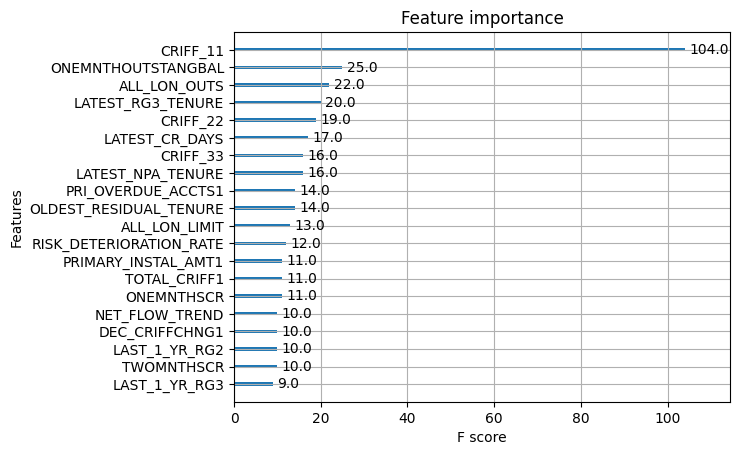

In [53]:
import matplotlib.pyplot as plt

# Plot feature importance
plt.figure(figsize=(12, 8))
xgb.plot_importance(xgb_model, max_num_features=20)
plt.show()

In [14]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, roc_auc_score

# We'll use the same sample_df you created earlier
X = sample_df.drop('TARGET', axis=1)
y = sample_df['TARGET']

# Identify categorical feature indices (important for CatBoost)
cat_features_indices = [i for i, col in enumerate(X.columns) if col in categorical_cols]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [15]:
# Initialize CatBoost with sensible defaults
cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    scale_pos_weight=9,  # for your 90/10 class imbalance
    cat_features=cat_features_indices,
    verbose=100  # shows progress every 100 iterations
)

# Train the model
cat_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds=50,
    plot=True  # shows training visualization
)

# Evaluate
train_pred = cat_model.predict(X_train)
test_pred = cat_model.predict(X_test)

print("\nTraining Report:")
print(classification_report(y_train, train_pred))
print(f"Training ROC-AUC: {roc_auc_score(y_train, cat_model.predict_proba(X_train)[:,1])}")

print("\nTest Report:")
print(classification_report(y_test, test_pred))
print(f"Test ROC-AUC: {roc_auc_score(y_test, cat_model.predict_proba(X_test)[:,1])}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8026880	best: 0.8026880 (0)	total: 111ms	remaining: 55.3s
100:	test: 0.8701050	best: 0.8701050 (100)	total: 4.07s	remaining: 16.1s
200:	test: 0.8820898	best: 0.8820898 (200)	total: 7.87s	remaining: 11.7s
300:	test: 0.8931598	best: 0.8932425 (297)	total: 11.6s	remaining: 7.68s
400:	test: 0.8966448	best: 0.8966448 (400)	total: 15.3s	remaining: 3.79s
499:	test: 0.8980966	best: 0.8981126 (496)	total: 19s	remaining: 0us

bestTest = 0.898112636
bestIteration = 496

Shrink model to first 497 iterations.

Training Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.91     46510
           1       0.42      0.92      0.57      5622

    accuracy                           0.85     52132
   macro avg       0.70      0.88      0.74     52132
weighted avg       0.93      0.85      0.88     52132

Training ROC-AUC: 0.9471811106060359

Test Report:
              precision    recall  f1-score   support

           0       0.97      0.84   

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Use the same sample_df from before
X = sample_df.drop('TARGET', axis=1)
y = sample_df['TARGET']

# Preprocessing for categorical variables (Random Forest needs encoded categories)
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, stratify=y, random_state=42
)

In [17]:
# Initialize Random Forest with class weighting
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    class_weight='balanced_subsample',  # handles 90/10 imbalance
    random_state=42,
    n_jobs=-1  # use all cores
)

# Train model
rf_model.fit(X_train, y_train)

# Evaluate
train_pred = rf_model.predict(X_train)
train_proba = rf_model.predict_proba(X_train)[:, 1]
test_pred = rf_model.predict(X_test)
test_proba = rf_model.predict_proba(X_test)[:, 1]

print("\nTraining Report:")
print(classification_report(y_train, train_pred))
print(f"Training ROC-AUC: {roc_auc_score(y_train, train_proba)}")

print("\nTest Report:")
print(classification_report(y_test, test_pred))
print(f"Test ROC-AUC: {roc_auc_score(y_test, test_proba)}")


Training Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.92     46510
           1       0.42      0.82      0.56      5622

    accuracy                           0.86     52132
   macro avg       0.70      0.84      0.74     52132
weighted avg       0.92      0.86      0.88     52132

Training ROC-AUC: 0.9221347876133331

Test Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90     11627
           1       0.34      0.64      0.45      1406

    accuracy                           0.83     13033
   macro avg       0.65      0.75      0.67     13033
weighted avg       0.89      0.83      0.85     13033

Test ROC-AUC: 0.8368389121264689


In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LeakyReLU
from sklearn.preprocessing import StandardScaler

## Data Preparation
# Use the same sample_df from before
X = sample_df.drop('TARGET', axis=1)
y = sample_df['TARGET']

# Preprocessing:
# 1. One-hot encode categorical variables
# 2. Convert boolean to int
# 3. Scale numerical features

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Convert boolean to int
for col in boolean_cols:
    X_encoded[col] = X_encoded[col].astype(int)

# Scale numerical features
scaler = StandardScaler()
num_cols = X.select_dtypes(include=['int64','float64']).columns
X_encoded[num_cols] = scaler.fit_transform(X_encoded[num_cols])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, stratify=y, random_state=42
)

## Neural Network Architecture
model = Sequential([
    Dense(64, input_shape=(X_train.shape[1],)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.05),
    
    Dense(32),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.05),
    
    Dense(16),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.05),
    
    Dense(8),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.05),
    
    Dense(1, activation='sigmoid')
])

# Custom weighted binary crossentropy for 90/10 class imbalance
def weighted_binary_crossentropy(y_true, y_pred):
    weight = 9.0  # ratio of negative to positive samples (90/10)
    y_true = tf.cast(y_true, tf.float32)
    loss = - (weight * y_true * tf.math.log(y_pred + 1e-7) + 
             (1 - y_true) * tf.math.log(1 - y_pred + 1e-7))
    return tf.reduce_mean(loss)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=weighted_binary_crossentropy,
              metrics=['accuracy', 
                      tf.keras.metrics.AUC(name='auc')])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_auc',
                              patience=30,
                              mode='max',
                              restore_best_weights=True)

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

## Evaluation
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Predictions
test_pred = (model.predict(X_test) > 0.5).astype(int)
test_proba = model.predict(X_test)

print("\nTest Report:")
print(classification_report(y_test, test_pred))
print(f"Test ROC-AUC: {roc_auc_score(y_test, test_proba)}")

2025-08-01 04:53:45.258913: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754024025.658145      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754024025.753713      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argume

Epoch 1/100
815/815 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6280 - auc: 0.7475 - loss: 1.1100 - val_accuracy: 0.7012 - val_auc: 0.8177 - val_loss: 0.9808
Epoch 2/100
815/815 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7213 - auc: 0.8302 - loss: 0.9343 - val_accuracy: 0.7315 - val_auc: 0.8216 - val_loss: 0.9650
Epoch 3/100
815/815 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7358 - auc: 0.8440 - loss: 0.9017 - val_accuracy: 0.7261 - val_auc: 0.8230 - val_loss: 0.9623
Epoch 4/100
815/815 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7380 - auc: 0.8538 - loss: 0.8809 - val_accuracy: 0.7247 - val_auc: 0.8225 - val_loss: 0.9646
Epoch 5/100
815/815 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7397 - auc: 0.8608 - loss: 0.8570 - val_accuracy: 0.7528 - val_auc: 0.8180 - val_loss: 0.9983
Epoch 6/100
815/815 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7372 - auc: 0.8661 - loss: 0.8447 - val_accuracy: 0.7552 - val_auc: 0.8203 - val_loss: 1.0101
Epoch 7/100
815/815 ━━━━━━━━━━━━━

NameError: name 'plt' is not defined

Reduced from 804 to 302 features


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.4653 - auc: 0.4918 - loss: nan - val_accuracy: 0.4483 - val_auc: 0.4729 - val_loss: nan
Epoch 2/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4800 - auc: 0.5088 - loss: nan - val_accuracy: 0.4427 - val_auc: 0.4511 - val_loss: nan
Epoch 3/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4935 - auc: 0.5318 - loss: nan - val_accuracy: 0.4516 - val_auc: 0.4854 - val_loss: nan
Epoch 4/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5167 - auc: 0.5539 - loss: nan - val_accuracy: 0.4672 - val_auc: 0.5108 - val_loss: nan
Epoch 5/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5294 - auc: 0.5540 - loss: nan - val_accuracy: 0.4917 - val_auc: 0.5150 - val_loss: nan
Epoch 6/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5174 - auc: 0.5559 - loss: nan - val_accuracy: 0.4905 - val_auc: 0.5173 - val_loss: nan
Epoch 7/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5332 - auc

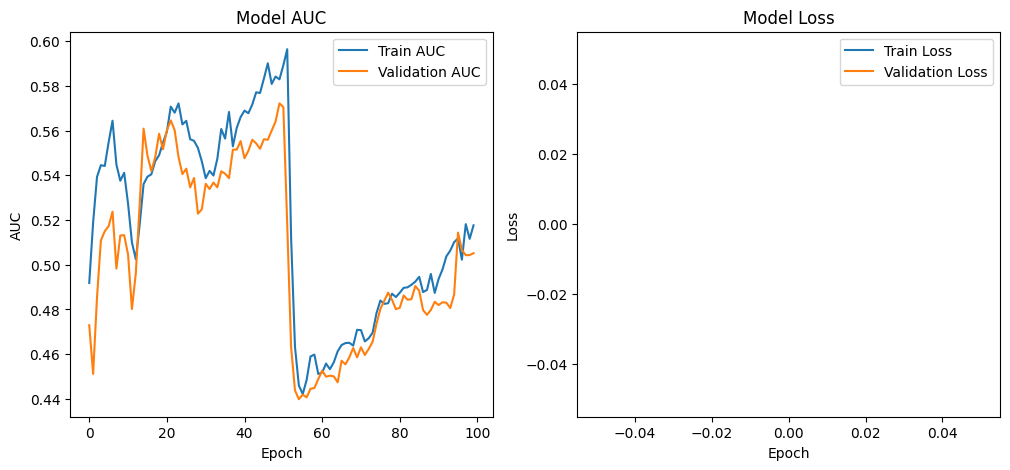

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Test Report:
              precision    recall  f1-score   support

           0       0.49      0.79      0.60       407
           1       0.64      0.32      0.43       492

    accuracy                           0.53       899
   macro avg       0.57      0.55      0.51       899
weighted avg       0.57      0.53      0.51       899

Test ROC-AUC: 0.5490501588062564

PCA Explained Variance Ratio:
Total variance explained: 0.80
Number of components: 302


In [59]:
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.model_selection import train_test_split
# from sklearn.utils import resample
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.layers import LeakyReLU
# from sklearn.metrics import classification_report, roc_auc_score
# import matplotlib.pyplot as plt

# # Load and prepare data
# X = sample_df.drop('TARGET', axis=1)
# y = sample_df['TARGET']

# # Downsample majority class (class 0)
# df_majority = sample_df[sample_df['TARGET'] == 0]
# df_minority = sample_df[sample_df['TARGET'] == 1]

# # Downsample to 10% of original majority class size (while keeping all minority samples)
# df_majority_downsampled = resample(df_majority,
#                                   replace=False,
#                                   n_samples=int(len(df_majority)*0.1),
#                                   random_state=42)

# # Combine minority class with downsampled majority class
# df_balanced = pd.concat([df_majority_downsampled, df_minority])

# # Prepare balanced dataset
# X_balanced = df_balanced.drop('TARGET', axis=1)
# y_balanced = df_balanced['TARGET']

# # Preprocessing pipeline
# def preprocess_data(X):
#     # Convert boolean to int
#     bool_cols = X.select_dtypes(include=['bool']).columns
#     X[bool_cols] = X[bool_cols].astype(int)
    
#     # One-hot encode categorical variables
#     cat_cols = X.select_dtypes(include=['object', 'category']).columns
#     X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
    
#     # Scale numerical features
#     num_cols = X.select_dtypes(include=['int64','float64']).columns
#     scaler = StandardScaler()
#     X[num_cols] = scaler.fit_transform(X[num_cols])
    
#     return X

# X_processed = preprocess_data(X_balanced)

# # Apply PCA for feature reduction
# pca = PCA(n_components=0.8)  # Keep 95% of variance
# X_pca = pca.fit_transform(X_processed)
# print(f"Reduced from {X_processed.shape[1]} to {X_pca.shape[1]} features")

# # Split data
# X_train, X_test, y_train, y_test = train_test_split(
#     X_pca, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
# )

# # Neural Network Architecture
# model = Sequential([
#     Dense(256, input_shape=(X_train.shape[1],)), 
#     LeakyReLU(alpha=0.05),
#     BatchNormalization(),

#     Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#     LeakyReLU(alpha=0.05),
#     BatchNormalization(),

#     Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#     LeakyReLU(alpha=0.05),
#     BatchNormalization(),
    
#     Dense(32, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#     LeakyReLU(alpha=0.05),
#     BatchNormalization(),
    
#     Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#     LeakyReLU(alpha=0.05),
#     BatchNormalization(),
    
#     Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#     LeakyReLU(alpha=0.05),
#     BatchNormalization(),
    
#     Dense(1, activation='tanh')
# ])

# # Custom weighted loss (less extreme now due to downsampling)
# def weighted_binary_crossentropy(y_true, y_pred):
#     weight = 1.2  # Reduced from 9.0 since we downsampled
#     y_true = tf.cast(y_true, tf.float32)
#     loss = - (weight * y_true * tf.math.log(y_pred + 1e-7) + 
#              (1 - y_true) * tf.math.log(1 - y_pred + 1e-7))
#     return tf.reduce_mean(loss)

# # Compile model
# model.compile(optimizer=Adam(learning_rate=0.001),
#               loss=weighted_binary_crossentropy,
#               metrics=['accuracy', 
#                       tf.keras.metrics.AUC(name='auc')])

# # Early stopping callback
# early_stopping = EarlyStopping(monitor='val_auc',
#                               patience=50,
#                               mode='max',
#                               restore_best_weights=True,
#                               min_delta=0.001)

# # Train model
# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_test, y_test),
#     epochs=200,
#     batch_size=128,
#     callbacks=[early_stopping],
#     verbose=1
# )

# # Plot training history
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['auc'], label='Train AUC')
# plt.plot(history.history['val_auc'], label='Validation AUC')
# plt.title('Model AUC')
# plt.ylabel('AUC')
# plt.xlabel('Epoch')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend()
# plt.show()

# # Evaluate
# test_pred = (model.predict(X_test) > 0.5).astype(int)
# test_proba = model.predict(X_test)

# print("\nTest Report:")
# print(classification_report(y_test, test_pred))
# print(f"Test ROC-AUC: {roc_auc_score(y_test, test_proba)}")

# # Print PCA information
# print("\nPCA Explained Variance Ratio:")
# print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.2f}")
# print(f"Number of components: {pca.n_components_}")

In [68]:
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import classification_report, roc_auc_score

# # Focal Loss Function
# def focal_loss(gamma=2., alpha=0.25):
#     def focal_loss_fixed(y_true, y_pred):
#         epsilon = 1e-7
#         y_true = tf.cast(y_true, tf.float32)
#         y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
#         cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
#         weight = alpha * y_true * tf.pow(1 - y_pred, gamma) + (1 - alpha) * (1 - y_true) * tf.pow(y_pred, gamma)
#         return tf.reduce_mean(weight * cross_entropy)
#     return focal_loss_fixed

# # Assume sample_df is ready and 'TARGET' is the target column
# X = sample_df.drop('TARGET', axis=1)
# y = sample_df['TARGET']

# # Preprocessing: Convert categorical, scale, etc.
# def preprocess(X):
#     bool_cols = X.select_dtypes(include='bool').columns
#     X[bool_cols] = X[bool_cols].astype(int)
    
#     cat_cols = X.select_dtypes(include=['object', 'category']).columns
#     X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
    
#     num_cols = X.select_dtypes(include=['int64', 'float64']).columns
#     scaler = StandardScaler()
#     X[num_cols] = scaler.fit_transform(X[num_cols])
#     return X

# X_processed = preprocess(X)
# X_train, X_test, y_train, y_test = train_test_split(X_processed, y, stratify=y, test_size=0.2, random_state=42)

# # Model Architecture
# model = tf.keras.Sequential([
#     tf.keras.layers.Dense(128, input_shape=(X_train.shape[1],)),
#     tf.keras.layers.LeakyReLU(0.1),
#     tf.keras.layers.BatchNormalization(),

#     tf.keras.layers.Dense(64),
#     tf.keras.layers.LeakyReLU(0.1),
#     tf.keras.layers.BatchNormalization(),

#     tf.keras.layers.Dense(32),
#     tf.keras.layers.LeakyReLU(0.1),
#     tf.keras.layers.BatchNormalization(),

#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# # Compile with Focal Loss
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
#               loss=focal_loss(gamma=2.0, alpha=0.25),
#               metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

# # Early Stopping
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_auc', patience=15, mode='max', restore_best_weights=True
# )

# # Train
# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_test, y_test),
#     epochs=100,
#     batch_size=128,
#     callbacks=[early_stopping],
#     verbose=1
# )

# # Evaluate
# y_proba = model.predict(X_test)
# y_pred = (y_proba > 0.5).astype(int)

# print("\nClassification Report:\n")
# print(classification_report(y_test, y_pred))
# print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba)}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6391 - auc: 0.5727 - loss: 0.1487 - val_accuracy: 0.8867 - val_auc: 0.6643 - val_loss: 0.0428
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8998 - auc: 0.7767 - loss: 0.0355 - val_accuracy: 0.8906 - val_auc: 0.7215 - val_loss: 0.0311
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9000 - auc: 0.8626 - loss: 0.0250 - val_accuracy: 0.8911 - val_auc: 0.7565 - val_loss: 0.0313
Epoch 4/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9075 - auc: 0.9076 - loss: 0.0213 - val_accuracy: 0.8926 - val_auc: 0.7559 - val_loss: 0.0317
Epoch 5/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9110 - auc: 0.9365 - loss: 0.0187 - val_accuracy: 0.8937 - val_auc: 0.7528 - val_loss: 0.0337
Epoch 6/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9198 - auc: 0.9562 - loss: 0.0165 - val_accuracy: 0.8904 - val_auc: 0.7491 - val_loss: 0.0378
Epoch 7/100
143/143 ━━━━━━━━━━━━━

In [69]:
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import classification_report, roc_auc_score

# # ---------- Effective Number Class Weights ----------
# def get_cb_weights(y, beta=0.9999):
#     """Compute class-balanced weights based on effective number of samples"""
#     class_counts = np.bincount(y)
#     effective_num = 1.0 - np.power(beta, class_counts)
#     weights = (1.0 - beta) / np.array(effective_num)
#     weights = weights / np.sum(weights) * len(class_counts)  # Normalize to class count
#     return weights

# # ---------- CB Loss (Binary Version) ----------
# def cb_loss(weights, beta=0.9999):
#     def loss(y_true, y_pred):
#         y_true = tf.cast(y_true, tf.float32)
#         weights_tensor = y_true * weights[1] + (1. - y_true) * weights[0]
#         bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
#         return tf.reduce_mean(weights_tensor * bce)
#     return loss

# # Assume sample_df is ready and 'TARGET' is the target column
# X = sample_df.drop('TARGET', axis=1)
# y = sample_df['TARGET'].values

# # Preprocess features
# def preprocess(X):
#     bool_cols = X.select_dtypes(include='bool').columns
#     X[bool_cols] = X[bool_cols].astype(int)
    
#     cat_cols = X.select_dtypes(include=['object', 'category']).columns
#     X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
    
#     num_cols = X.select_dtypes(include=['int64', 'float64']).columns
#     scaler = StandardScaler()
#     X[num_cols] = scaler.fit_transform(X[num_cols])
#     return X

# X_processed = preprocess(X)
# X_train, X_test, y_train, y_test = train_test_split(X_processed, y, stratify=y, test_size=0.2, random_state=42)

# # Get CB weights
# cb_weights = get_cb_weights(y_train, beta=0.9999)
# print(f"Class-balanced weights: {cb_weights}")

# # Model
# model = tf.keras.Sequential([
#     tf.keras.layers.Dense(128, input_shape=(X_train.shape[1],)),
#     tf.keras.layers.LeakyReLU(0.1),
#     tf.keras.layers.BatchNormalization(),

#     tf.keras.layers.Dense(64),
#     tf.keras.layers.LeakyReLU(0.1),
#     tf.keras.layers.BatchNormalization(),

#     tf.keras.layers.Dense(32),
#     tf.keras.layers.LeakyReLU(0.1),
#     tf.keras.layers.BatchNormalization(),

#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
#               loss=cb_loss(cb_weights),
#               metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_auc', patience=15, mode='max', restore_best_weights=True
# )

# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_test, y_test),
#     epochs=100,
#     batch_size=128,
#     callbacks=[early_stopping],
#     verbose=1
# )

# # Evaluation
# y_proba = model.predict(X_test)
# y_pred = (y_proba > 0.5).astype(int)

# print("\nClassification Report:\n")
# print(classification_report(y_test, y_pred))
# print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba)}")


Class-balanced weights: [0.36360484 1.63639516]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.6664 - auc: 0.6561 - loss: 0.3175 - val_accuracy: 0.8816 - val_auc: 0.7143 - val_loss: 0.1984
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8999 - auc: 0.8498 - loss: 0.1640 - val_accuracy: 0.8902 - val_auc: 0.7613 - val_loss: 0.1547
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9138 - auc: 0.9018 - loss: 0.1162 - val_accuracy: 0.8882 - val_auc: 0.7469 - val_loss: 0.1578
Epoch 4/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9250 - auc: 0.9351 - loss: 0.0970 - val_accuracy: 0.8878 - val_auc: 0.7525 - val_loss: 0.1618
Epoch 5/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9373 - auc: 0.9546 - loss: 0.0830 - val_accuracy: 0.8829 - val_auc: 0.7392 - val_loss: 0.1803
Epoch 6/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9479 - auc: 0.9651 - loss: 0.0721 - val_accuracy: 0.8865 - val_auc: 0.7464 - val_loss: 0.1799
Epoch 7/100
143/143 ━━━━━━━━━━━━━

In [70]:
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import classification_report, roc_auc_score

# # Asymmetric Loss
# def asymmetric_loss(gamma_neg=4, gamma_pos=1, clip=0.05):
#     def loss(y_true, y_pred):
#         y_true = tf.cast(y_true, tf.float32)
#         y_pred = tf.clip_by_value(y_pred, 1e-8, 1 - 1e-8)

#         pos_loss = -y_true * tf.math.pow(1 - y_pred, gamma_pos) * tf.math.log(y_pred)
#         neg_loss = -(1 - y_true) * tf.math.pow(y_pred, gamma_neg) * tf.math.log(1 - y_pred)

#         # Optional: clip negatives to avoid dominating
#         if clip is not None:
#             neg_loss = tf.clip_by_value(neg_loss, clip, 10.0)

#         return tf.reduce_mean(pos_loss + neg_loss)
#     return loss

# # Dataset prep (same as before)
# X = sample_df.drop('TARGET', axis=1)
# y = sample_df['TARGET'].values

# def preprocess(X):
#     bool_cols = X.select_dtypes(include='bool').columns
#     X[bool_cols] = X[bool_cols].astype(int)
    
#     cat_cols = X.select_dtypes(include=['object', 'category']).columns
#     X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
    
#     num_cols = X.select_dtypes(include=['int64', 'float64']).columns
#     scaler = StandardScaler()
#     X[num_cols] = scaler.fit_transform(X[num_cols])
#     return X

# X_processed = preprocess(X)
# X_train, X_test, y_train, y_test = train_test_split(X_processed, y, stratify=y, test_size=0.2, random_state=42)

# # Model
# model = tf.keras.Sequential([
#     tf.keras.layers.Dense(128, input_shape=(X_train.shape[1],)),
#     tf.keras.layers.LeakyReLU(0.1),
#     tf.keras.layers.BatchNormalization(),

#     tf.keras.layers.Dense(64),
#     tf.keras.layers.LeakyReLU(0.1),
#     tf.keras.layers.BatchNormalization(),

#     tf.keras.layers.Dense(32),
#     tf.keras.layers.LeakyReLU(0.1),
#     tf.keras.layers.BatchNormalization(),

#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
#               loss=asymmetric_loss(gamma_neg=4, gamma_pos=1, clip=0.05),
#               metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_auc', patience=15, mode='max', restore_best_weights=True
# )

# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_test, y_test),
#     epochs=100,
#     batch_size=128,
#     callbacks=[early_stopping],
#     verbose=1
# )

# # Evaluation
# y_proba = model.predict(X_test)
# y_pred = (y_proba > 0.5).astype(int)

# print("\nClassification Report:\n")
# print(classification_report(y_test, y_pred))
# print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba)}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.5966 - auc: 0.6087 - loss: 0.1770 - val_accuracy: 0.7764 - val_auc: 0.6967 - val_loss: 0.1015
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7544 - auc: 0.8219 - loss: 0.0887 - val_accuracy: 0.7624 - val_auc: 0.7127 - val_loss: 0.0971
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7651 - auc: 0.8804 - loss: 0.0826 - val_accuracy: 0.7264 - val_auc: 0.7234 - val_loss: 0.0982
Epoch 4/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7766 - auc: 0.9102 - loss: 0.0802 - val_accuracy: 0.7387 - val_auc: 0.7361 - val_loss: 0.0969
Epoch 5/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7801 - auc: 0.9335 - loss: 0.0790 - val_accuracy: 0.7804 - val_auc: 0.7473 - val_loss: 0.0989
Epoch 6/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8070 - auc: 0.9412 - loss: 0.0762 - val_accuracy: 0.7865 - val_auc: 0.7415 - val_loss: 0.1004
Epoch 7/100
143/143 ━━━━━━━━━━━━━

In [20]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Step 1: Data Prep
X = sample_df.drop('TARGET', axis=1)
y = sample_df['TARGET']
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, stratify=y, random_state=42
)

# Step 2: Define baseline models (quick training setup)
models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=50, max_depth=5, class_weight='balanced_subsample', n_jobs=-1, random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=50, max_depth=3, learning_rate=0.1, scale_pos_weight=10,
        use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1
    ),
    "CatBoost": CatBoostClassifier(
        iterations=50, depth=3, learning_rate=0.1, scale_pos_weight=10,
        verbose=0, random_state=42
    ),
    "DecisionTree": DecisionTreeClassifier(
        max_depth=5, class_weight='balanced', random_state=42
    ),
    "KNN": KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    "LogisticRegression": LogisticRegression(
        class_weight='balanced', max_iter=500, solver='lbfgs', random_state=42, n_jobs=-1
    ),
    "GradientBoosting": GradientBoostingClassifier(
        n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42
    ),
    "ExtraTrees": ExtraTreesClassifier(
        n_estimators=50, max_depth=5, class_weight='balanced', random_state=42, n_jobs=-1
    )
}

# Step 3: Train, evaluate, store results with progress bar
results = []

print("Training models and calculating F1 scores...\n")
for name in tqdm(models):
    model = models[name]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Average F1-score across both classes
    f1_avg = (report['0']['f1-score'] + report['1']['f1-score']) / 2
    
    results.append({
        'model': name,
        'f1_avg': f1_avg,
        'report': classification_report(y_test, y_pred)
    })

# Step 4: Sort and display top 3
results_sorted = sorted(results, key=lambda x: x['f1_avg'], reverse=True)

print("\nTop 3 Models by Average F1 Score:\n")
for i in range(3):
    model_info = results_sorted[i]
    print(f"Model: {model_info['model']}")
    print(f"Average F1 Score: {model_info['f1_avg']:.4f}")
    print("Classification Report:")
    print(model_info['report'])
    print("-" * 50)


Training models and calculating F1 scores...



 62%|██████▎   | 5/8 [00:38<00:30, 10.12s/it]/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 8/8 [03:32<00:00, 26.52s/it]


Top 3 Models by Average F1 Score:

Model: GradientBoosting
Average F1 Score: 0.6594
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     11627
           1       0.69      0.25      0.37      1406

    accuracy                           0.91     13033
   macro avg       0.80      0.62      0.66     13033
weighted avg       0.89      0.91      0.89     13033

--------------------------------------------------
Model: XGBoost
Average F1 Score: 0.6301
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.74      0.84     11627
           1       0.28      0.82      0.42      1406

    accuracy                           0.75     13033
   macro avg       0.63      0.78      0.63     13033
weighted avg       0.90      0.75      0.80     13033

--------------------------------------------------
Model: DecisionTree
Average F1 Score: 0.6188
Classification Report:
     

In [24]:
!pip install -U imbalanced-learn --q


In [26]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import RandomOverSampler  # <-- use this instead of SMOTE

# Step 1: Data Prep
X = sample_df.drop('TARGET', axis=1)
y = sample_df['TARGET']
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Step 2: Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, stratify=y, random_state=42
)

# Step 3: Apply Random OverSampling to balance classes in training set
ros = RandomOverSampler(random_state=42)
X_train_bal, y_train_bal = ros.fit_resample(X_train, y_train)

# Step 4: Define models (fast but improved for class imbalance)
models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=100, max_depth=6, class_weight='balanced_subsample', n_jobs=-1, random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=100, max_depth=4, learning_rate=0.1, scale_pos_weight=1,
        use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1
    ),
    "CatBoost": CatBoostClassifier(
        iterations=100, depth=4, learning_rate=0.1, scale_pos_weight=1,
        verbose=0, random_state=42
    ),
    "DecisionTree": DecisionTreeClassifier(
        max_depth=6, class_weight='balanced', random_state=42
    ),
    "KNN": KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    "LogisticRegression": LogisticRegression(
        class_weight='balanced', max_iter=1000, solver='lbfgs', random_state=42, n_jobs=-1
    ),
    "GradientBoosting": GradientBoostingClassifier(
        n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42
    ),
    "ExtraTrees": ExtraTreesClassifier(
        n_estimators=100, max_depth=6, class_weight='balanced', random_state=42, n_jobs=-1
    )
}

# Step 5: Train and evaluate models with progress bar
results = []

print("Training models with RandomOverSampler and evaluating...\n")
for name in tqdm(models):
    model = models[name]
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test)

    # Classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    f1_avg = (report['0']['f1-score'] + report['1']['f1-score']) / 2

    results.append({
        'model': name,
        'f1_avg': f1_avg,
        'report_str': classification_report(y_test, y_pred)
    })

# Step 6: Sort and display top 3 models
results_sorted = sorted(results, key=lambda x: x['f1_avg'], reverse=True)

print("\nTop 3 Models by Average F1 Score:\n")
for i in range(3):
    model_info = results_sorted[i]
    print(f"Model: {model_info['model']}")
    print(f"Average F1 Score: {model_info['f1_avg']:.4f}")
    print("Classification Report:")
    print(model_info['report_str'])
    print("-" * 50)


ImportError: cannot import name 'UnsetMetadataPassedError' from 'sklearn.exceptions' (/usr/local/lib/python3.11/dist-packages/sklearn/exceptions.py)

In [30]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# SOLUTION 1: Manual Random Oversampling (No external library needed)
def manual_random_oversample(X, y, random_state=42):
    """
    Manually implement random oversampling without external dependencies
    """
    np.random.seed(random_state)
    
    # Get class counts
    unique, counts = np.unique(y, return_counts=True)
    max_count = max(counts)
    
    # Combine X and y for easier manipulation
    combined = pd.concat([X.reset_index(drop=True), y.reset_index(drop=True)], axis=1)
    y_col = combined.columns[-1]
    
    oversampled_data = []
    
    for class_label in unique:
        class_data = combined[combined[y_col] == class_label]
        current_count = len(class_data)
        
        if current_count < max_count:
            # Need to oversample this class
            additional_samples = max_count - current_count
            # Sample with replacement
            additional_data = class_data.sample(n=additional_samples, replace=True, random_state=random_state)
            oversampled_data.append(pd.concat([class_data, additional_data]))
        else:
            oversampled_data.append(class_data)
    
    # Combine all oversampled data
    final_data = pd.concat(oversampled_data, ignore_index=True)
    
    # Shuffle the data
    final_data = final_data.sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    # Split back into X and y
    X_resampled = final_data.drop(columns=[y_col])
    y_resampled = final_data[y_col]
    
    return X_resampled, y_resampled

# Step 1: Data Prep
X = sample_df.drop('TARGET', axis=1)
y = sample_df['TARGET']
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Step 2: Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, stratify=y, random_state=42
)

# Step 3: Apply Manual Random OverSampling to balance classes in training set
X_train_bal, y_train_bal = manual_random_oversample(X_train, y_train, random_state=42)

# Step 4: Define models (fast but improved for class imbalance)
models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=100, max_depth=6, class_weight='balanced_subsample', n_jobs=-1, random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=100, max_depth=4, learning_rate=0.1, scale_pos_weight=1,
        use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1
    ),
    "CatBoost": CatBoostClassifier(
        iterations=100, depth=4, learning_rate=0.1, scale_pos_weight=1,
        verbose=0, random_state=42
    ),
    "DecisionTree": DecisionTreeClassifier(
        max_depth=6, class_weight='balanced', random_state=42
    ),
    "KNN": KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    "LogisticRegression": LogisticRegression(
        class_weight='balanced', max_iter=100, solver='lbfgs', random_state=42, n_jobs=-1
    ),
    "GradientBoosting": GradientBoostingClassifier(
        n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42
    ),
    "ExtraTrees": ExtraTreesClassifier(
        n_estimators=100, max_depth=6, class_weight='balanced', random_state=42, n_jobs=-1
    )
}

# Step 5: Train and evaluate models with progress bar
results = []
print("Training models with Manual Random Oversampling and evaluating...\n")

for name in tqdm(models):
    model = models[name]
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test)
    
    # Classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    f1_avg = (report['0']['f1-score'] + report['1']['f1-score']) / 2
    
    results.append({
        'model': name,
        'f1_avg': f1_avg,
        'report_str': classification_report(y_test, y_pred)
    })

# Step 6: Sort and display top 3 models
results_sorted = sorted(results, key=lambda x: x['f1_avg'], reverse=True)

print("\nTop 3 Models by Average F1 Score:\n")
for i in range(3):
    model_info = results_sorted[i]
    print(f"Model: {model_info['model']}")
    print(f"Average F1 Score: {model_info['f1_avg']:.4f}")
    print("Classification Report:")
    print(model_info['report_str'])
    print("-" * 50)

Training models with Manual Random Oversampling and evaluating...



 62%|██████▎   | 5/8 [01:18<00:56, 18.95s/it]/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 75%|███████▌  | 6/8 [05:55<01:58, 59.19s/it]


KeyboardInterrupt: 

In [32]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import time

# Try to import models individually with fallbacks
available_models = {}

# Basic Linear Models (Most Compatible)
try:
    from sklearn.linear_model import LogisticRegression
    available_models['LogisticRegression'] = LogisticRegression
except ImportError:
    print("LogisticRegression not available")

try:
    from sklearn.linear_model import RidgeClassifier
    available_models['RidgeClassifier'] = RidgeClassifier
except ImportError:
    print("RidgeClassifier not available")

try:
    from sklearn.linear_model import SGDClassifier
    available_models['SGDClassifier'] = SGDClassifier
except ImportError:
    print("SGDClassifier not available")

# Tree-based (usually stable)
try:
    from sklearn.tree import DecisionTreeClassifier
    available_models['DecisionTreeClassifier'] = DecisionTreeClassifier
except ImportError:
    print("DecisionTreeClassifier not available")

# SVM
try:
    from sklearn.svm import LinearSVC
    available_models['LinearSVC'] = LinearSVC
except ImportError:
    print("LinearSVC not available")

# Neighbors
try:
    from sklearn.neighbors import KNeighborsClassifier
    available_models['KNeighborsClassifier'] = KNeighborsClassifier
except ImportError:
    print("KNeighborsClassifier not available")

# Dummy classifier for baseline
try:
    from sklearn.dummy import DummyClassifier
    available_models['DummyClassifier'] = DummyClassifier
except ImportError:
    print("DummyClassifier not available")

print(f"Available models: {list(available_models.keys())}")

# Manual implementations for models that might not import
class SimpleNaiveBayes:
    """Simple Gaussian Naive Bayes implementation"""
    def __init__(self):
        self.class_priors = {}
        self.feature_means = {}
        self.feature_vars = {}
        self.classes = None
        
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        self.classes = np.unique(y)
        
        for cls in self.classes:
            cls_mask = (y == cls)
            self.class_priors[cls] = np.sum(cls_mask) / len(y)
            
            # Calculate mean and variance for each feature for this class
            X_cls = X[cls_mask]
            self.feature_means[cls] = np.mean(X_cls, axis=0)
            self.feature_vars[cls] = np.var(X_cls, axis=0) + 1e-9  # Add small value to avoid division by zero
    
    def predict(self, X):
        X = np.array(X)
        predictions = []
        
        for sample in X:
            log_probs = {}
            
            for cls in self.classes:
                # Log prior
                log_prob = np.log(self.class_priors[cls])
                
                # Log likelihood (assuming independence)
                for i, feature_val in enumerate(sample):
                    mean = self.feature_means[cls][i]
                    var = self.feature_vars[cls][i]
                    
                    # Gaussian probability density
                    log_prob += -0.5 * np.log(2 * np.pi * var) - 0.5 * ((feature_val - mean) ** 2) / var
                
                log_probs[cls] = log_prob
            
            # Predict class with highest log probability
            predicted_class = max(log_probs, key=log_probs.get)
            predictions.append(predicted_class)
        
        return np.array(predictions)

class SimpleCentroidClassifier:
    """Simple centroid-based classifier"""
    def __init__(self):
        self.centroids = {}
        self.classes = None
    
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        self.classes = np.unique(y)
        
        for cls in self.classes:
            cls_mask = (y == cls)
            self.centroids[cls] = np.mean(X[cls_mask], axis=0)
    
    def predict(self, X):
        X = np.array(X)
        predictions = []
        
        for sample in X:
            distances = {}
            for cls in self.classes:
                # Euclidean distance to centroid
                distances[cls] = np.linalg.norm(sample - self.centroids[cls])
            
            # Predict class with closest centroid
            predicted_class = min(distances, key=distances.get)
            predictions.append(predicted_class)
        
        return np.array(predictions)

# Manual Random Oversampling Function
def manual_random_oversample(X, y, random_state=42):
    """Manually implement random oversampling"""
    np.random.seed(random_state)
    
    # Get class counts
    unique, counts = np.unique(y, return_counts=True)
    max_count = max(counts)
    
    # Combine X and y for easier manipulation
    combined = pd.concat([X.reset_index(drop=True), y.reset_index(drop=True)], axis=1)
    y_col = combined.columns[-1]
    
    oversampled_data = []
    
    for class_label in unique:
        class_data = combined[combined[y_col] == class_label]
        current_count = len(class_data)
        
        if current_count < max_count:
            additional_samples = max_count - current_count
            additional_data = class_data.sample(n=additional_samples, replace=True, random_state=random_state)
            oversampled_data.append(pd.concat([class_data, additional_data]))
        else:
            oversampled_data.append(class_data)
    
    final_data = pd.concat(oversampled_data, ignore_index=True)
    final_data = final_data.sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    X_resampled = final_data.drop(columns=[y_col])
    y_resampled = final_data[y_col]
    
    return X_resampled, y_resampled

# Step 1: Data Prep
X = sample_df.drop('TARGET', axis=1)
y = sample_df['TARGET']
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Step 2: Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, stratify=y, random_state=42
)

# Step 3: Apply Manual Random OverSampling
X_train_bal, y_train_bal = manual_random_oversample(X_train, y_train, random_state=42)

# Step 4: Define available models with conservative parameters
models_to_test = {}

# Add custom implementations
models_to_test['SimpleNaiveBayes'] = SimpleNaiveBayes()
models_to_test['SimpleCentroid'] = SimpleCentroidClassifier()

# Add sklearn models that are available
if 'LogisticRegression' in available_models:
    models_to_test['LogisticRegression_fast'] = LogisticRegression(
        max_iter=100, solver='liblinear', random_state=42, class_weight='balanced'
    )

if 'RidgeClassifier' in available_models:
    models_to_test['RidgeClassifier_fast'] = RidgeClassifier(
        alpha=1.0, random_state=42, class_weight='balanced'
    )

if 'SGDClassifier' in available_models:
    models_to_test['SGDClassifier_fast'] = SGDClassifier(
        max_iter=50, random_state=42, class_weight='balanced', 
        loss='hinge', learning_rate='constant', eta0=0.01
    )

if 'DecisionTreeClassifier' in available_models:
    models_to_test['DecisionTree_shallow'] = DecisionTreeClassifier(
        max_depth=5, min_samples_split=20, random_state=42, class_weight='balanced'
    )

if 'LinearSVC' in available_models:
    models_to_test['LinearSVC_fast'] = LinearSVC(
        C=0.1, max_iter=100, random_state=42, class_weight='balanced'
    )

if 'KNeighborsClassifier' in available_models:
    models_to_test['KNN_fast'] = KNeighborsClassifier(n_neighbors=3)

if 'DummyClassifier' in available_models:
    models_to_test['DummyBaseline'] = DummyClassifier(strategy='stratified', random_state=42)

print(f"\nTesting {len(models_to_test)} models...")

# Step 5: Train and evaluate models
results = []
print("\nTraining ultra-compatible fast models...\n")

for name in tqdm(models_to_test, desc="Training Models"):
    model = models_to_test[name]
    
    try:
        # Time the training
        start_time = time.time()
        model.fit(X_train_bal, y_train_bal)
        training_time = time.time() - start_time
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        
        # Try to get detailed classification report
        try:
            report = classification_report(y_test, y_pred, output_dict=True)
            f1_avg = (report['0']['f1-score'] + report['1']['f1-score']) / 2
            report_str = classification_report(y_test, y_pred)
        except:
            # Fallback if classification report fails
            f1_avg = accuracy  # Use accuracy as proxy
            report_str = f"Accuracy: {accuracy:.4f}"
        
        results.append({
            'model': name,
            'training_time': training_time,
            'f1_avg': f1_avg,
            'accuracy': accuracy,
            'report_str': report_str,
            'status': 'Success'
        })
        
    except Exception as e:
        print(f"❌ {name} failed: {str(e)}")
        results.append({
            'model': name,
            'training_time': 0,
            'f1_avg': 0,
            'accuracy': 0,
            'report_str': f"Failed: {str(e)}",
            'status': 'Failed'
        })

# Step 6: Display results
successful_results = [r for r in results if r['status'] == 'Success']

if successful_results:
    # Sort by F1 score
    successful_results.sort(key=lambda x: x['f1_avg'], reverse=True)
    
    print("\n" + "="*70)
    print("RESULTS SUMMARY")
    print("="*70)
    print(f"{'Rank':<4} {'Model':<25} {'F1-Score':<10} {'Accuracy':<10} {'Time(s)':<8}")
    print("-"*70)
    
    for i, result in enumerate(successful_results, 1):
        print(f"{i:<4} {result['model']:<25} {result['f1_avg']:<10.4f} {result['accuracy']:<10.4f} {result['training_time']:<8.3f}")
    
    print("\n" + "="*70)
    print("DETAILED RESULTS - TOP 3 MODELS")
    print("="*70)
    
    for i in range(min(3, len(successful_results))):
        result = successful_results[i]
        print(f"\n🏆 Rank {i+1}: {result['model']}")
        print(f"   Training Time: {result['training_time']:.3f} seconds")
        print(f"   F1 Score: {result['f1_avg']:.4f}")
        print(f"   Accuracy: {result['accuracy']:.4f}")
        print("\n   Classification Report:")
        print(result['report_str'])
        print("-" * 50)

else:
    print("❌ No models trained successfully. There might be compatibility issues with your sklearn version.")
    print("\nTry updating sklearn:")
    print("pip install --upgrade scikit-learn")

print(f"\n✅ Completed! Tested {len(models_to_test)} models, {len(successful_results)} successful.")

Available models: ['LogisticRegression', 'RidgeClassifier', 'SGDClassifier', 'DecisionTreeClassifier', 'LinearSVC', 'KNeighborsClassifier', 'DummyClassifier']

Testing 9 models...

Training ultra-compatible fast models...



Training Models:  22%|██▏       | 2/9 [01:23<04:13, 36.16s/it]/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  # seed for srand in range [0..INT_MAX); due to limitations in Numpy
Training Models:  67%|██████▋   | 6/9 [03:19<01:04, 21.39s/it]/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  # seed for srand in range [0..INT_MAX); due to limitations in Numpy
Training Models: 100%|██████████| 9/9 [04:05<00:00, 27.26s/it]


RESULTS SUMMARY
Rank Model                     F1-Score   Accuracy   Time(s) 
----------------------------------------------------------------------
1    DecisionTree_shallow      0.6189     0.7417     7.866   
2    RidgeClassifier_fast      0.6019     0.7359     15.810  
3    SGDClassifier_fast        0.5664     0.7516     2.475   
4    KNN_fast                  0.5503     0.7718     0.722   
5    LogisticRegression_fast   0.4911     0.5777     89.128  
6    DummyBaseline             0.4051     0.4940     0.004   
7    SimpleCentroid            0.3777     0.4131     7.561   
8    LinearSVC_fast            0.3424     0.3665     11.878  
9    SimpleNaiveBayes          0.1692     0.1704     35.070  

DETAILED RESULTS - TOP 3 MODELS

🏆 Rank 1: DecisionTree_shallow
   Training Time: 7.866 seconds
   F1 Score: 0.6189
   Accuracy: 0.7417

   Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.73      0.84     11627
           1       